In [2]:
"""Model trained on MNIST dataset with variable input shape."""


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import (Conv2D, GlobalAveragePooling2D,
                                     MaxPooling2D, Input, Dense)
from tensorflow.keras.models import Model  # , Sequential
# from utils.exceptions import TooSmallInputShape
import matplotlib.pyplot as plt
import cv2

In [3]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train.astype('float32')
x_train = x_train / 255

In [4]:
# def nin_block(filters, kernel_size, strides, padding, inputs=None):
#     if inputs:
#         inp = Input(inputs)
#         x = Conv2D(filters, kernel_size, strides=strides,
#                    padding=padding, activation="relu")(inp)
#     else:
#         inp = Conv2D(filters, kernel_size, strides=strides,
#                      padding=padding, activation="relu")
#         x = inp

#     x = Conv2D(filters, kernel_size=1, activation="relu")(x)
#     x = Conv2D(filters, kernel_size=1, activation="relu")(x)
#     pool = MaxPooling2D(pool_size=(2, 2))(x)
#     return Model(inputs=inp, outputs=pool)


class NinBlock(tf.keras.layers.Layer):
    """Conv2D 3x3 -> 1x1 -> 1x1."""

    def __init__(self, filters, kernel_size, strides, padding, inputs=None):
        """Initialize layers."""
        super(NinBlock, self).__init__()
        # self.inputs = inputs
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

        self.conv1 = Conv2D(self.filters, self.kernel_size, strides=self.strides,
                            padding=self.padding, activation="relu")
        self.conv2 = Conv2D(self.filters, 1, activation="relu")
        self.conv3 = Conv2D(self.filters, 1, activation="relu")
        self.max_pool = MaxPooling2D(pool_size=(2, 2))

    def call(self, input_tensor):
        """Connect layers."""
        inp = self.conv1(input_tensor)
        x = self.conv2(inp)
        x = self.conv3(x)
        return self.max_pool(x)

In [24]:
class NinMnist(Model):
    """
    Model based on network in network architecture.
    It is adjusted for mnist dataset.
    """
    def __init__(self, inputs=[28, 28, 1]):
        super(NinMnist, self).__init__()
        self.inputs = inputs
        # self.minimum_input_shape = (14, 14, 1)

        self.block1 = NinBlock(16, 3, 1, "same")
        self.block2 = NinBlock(32, 3, 1, "same")
        self.block3 = NinBlock(64, 3, 1, "same")
        self.conv2d = Conv2D(filters=10, kernel_size=(3, 3), strides=1)
        self.global_pool = GlobalAveragePooling2D()
        self.FC1 = Dense(100, activation="relu")
        self.out = Dense(10, activation="softmax")

    def call(self, input_tensor):
        x = self.block1(input_tensor)
        x = self.block2(x)
        x = self.block3(x)
        x = self.conv2d(x)
        x = self.global_pool(x)
        x = self.FC1(x)
        return self.out(x)
        

    def model(self):
        inp = Input(self.inputs)
        return Model(inputs=inp, outputs=self.call(inp))

    # def build(self, input_shape):

    # #     width, height, channels = self.inputs
    # #     if (self.minimum_input_shape[0] > width or
    # #         self.minimum_input_shape[1] > height or
    # #         self.minimum_input_shape[2] > channels):
    # #         raise TooSmallInputShape(self.inputs, self.minimum_input_shape)
    #     inp = Input(shape=self.inputs)
    #     self.block1(inp)

In [25]:
model = NinMnist()
# model.build([28, 28, 1])
# X = np.random.uniform(size=(1, 28, 28, 1))
# for layer in model.layers:
#     X = layer(X)
#     print(layer.name, 'output shape:\t', X.shape)
# model.summary()

# print(model.output)
# model = Sequential()
# model.add(Input([28, 28, 1]))
# model.add(NinBlock(16, 3, 1, "same"))
# # model.add(NinBlock(32, 3, 1, "same"))
# # model.add(NinBlock(64, 3, 1, "same"))
# model.add(Conv2D(10, kernel_size=3))
# model.add(GlobalAveragePooling2D())

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=["accuracy"])
# model.build([None, 28, 28, 1])
model.model().summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
nin_block_3 (NinBlock)       (None, 14, 14, 16)        704       
_________________________________________________________________
nin_block_4 (NinBlock)       (None, 7, 7, 32)          6752      
_________________________________________________________________
nin_block_5 (NinBlock)       (None, 3, 3, 64)          26816     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 1, 10)          5770      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1100

In [26]:
model.fit(x_train, y_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 82s 43ms/step - loss: 0.5531 - accuracy: 0.8065
Epoch 2/3
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0776 - accuracy: 0.9756
Epoch 3/3
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0563 - accuracy: 0.9825


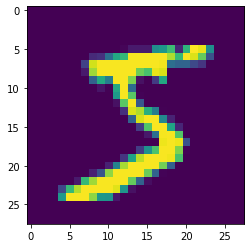

In [8]:
plt.imshow(x_train[0].reshape(28,28))

In [9]:
img = x_train[1].reshape(28,28).copy()

In [10]:
resized = cv2.resize(img, dsize=(56, 56), interpolation=cv2.INTER_CUBIC)

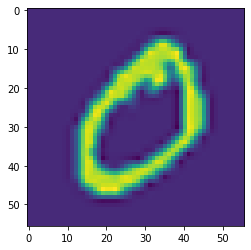

In [11]:
plt.imshow(resized)

In [12]:
model(resized.reshape(1, 56, 56, 1))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-2.9257307 ,  2.0133605 , -1.8579917 , -2.6004543 , -4.0973496 ,
        -3.6732726 , -2.7614985 , -0.69313836, -2.991588  , -3.3267787 ]],
      dtype=float32)>

In [13]:
x_train2 = np.array([cv2.resize(img, dsize=(56, 56), interpolation=cv2.INTER_CUBIC) for img in x_train[:30000]])

In [14]:
x_train2 = x_train2.reshape(-1, 56, 56, 1)

In [33]:
model.trainable = False

In [36]:
inp = Input([56, 56, 1])
x = inp
for layer in model.layers[:-2]:
    layer.trainable = False
    x = layer(x)
# x = model.layers[:-2](inp)
x = Dense(100, activation="relu")(x)
x = Dense(100, activation="relu")(x)
out = Dense(10, activation="softmax")(x)
model2 = Model(inputs=inp, outputs=out)

In [37]:
model2.input, model2.output

(<KerasTensor: shape=(None, 56, 56, 1) dtype=float32 (created by layer 'input_7')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_10')>)

In [38]:
model2(resized.reshape(1, 56, 56, 1))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.06669419, 0.06824775, 0.10636904, 0.16754939, 0.13861498,
        0.12150908, 0.03880468, 0.0939911 , 0.15656966, 0.04165015]],
      dtype=float32)>

In [39]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=["accuracy"])

In [40]:
model2.fit(x_train2, y_train[:30000], epochs = 3)

Epoch 1/3
938/938 [==============================] - 43s 45ms/step - loss: 1.3342 - accuracy: 0.5382
Epoch 2/3
938/938 [==============================] - 42s 45ms/step - loss: 0.7702 - accuracy: 0.7331
Epoch 3/3
938/938 [==============================] - 45s 48ms/step - loss: 0.6927 - accuracy: 0.7571


In [23]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
nin_mnist (NinMnist)         (None, 10)                40042     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 52,252
Trainable params: 12,210
Non-trainable params: 40,042
_________________________________________________________________


In [41]:
x_test2 = np.array([cv2.resize(img, dsize=(56, 56), interpolation=cv2.INTER_CUBIC) for img in x_test])
x_test2 = x_test2.reshape(-1, 56, 56, 1)

In [42]:
model2.evaluate(x_test2, y_test, batch_size=128)

79/79 [==============================] - 12s 140ms/step - loss: 863.7365 - accuracy: 0.3143


[863.7365112304688, 0.314300000667572]

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
vgg = VGG16(include_top=True)

In [ ]:
vgg.summary()